## Importing kagle dataset

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json `/.kaggle/

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [5]:
!kaggle datasets download -d tyb001/sarcasm-dataset

Dataset URL: https://www.kaggle.com/datasets/tyb001/sarcasm-dataset
License(s): unknown
100% 184k/184k [00:00<00:00, 732kB/s]
100% 184k/184k [00:00<00:00, 731kB/s]


## Unzipping file

In [6]:
import zipfile
zip_ref=zipfile.ZipFile("/content/sarcasm-dataset.zip","r")
zip_ref.extractall('/content')
zip_ref.close()

## Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import transformers
from transformers import TFDistilBertForSequenceClassification , DistilBertTokenizer

## Importing dataset

In [8]:
path="/content/Sarcasm Dataset.csv"
df=pd.read_csv(path)

In [55]:
df.sample(5)

,Unnamed: 0,tweet,sarcastic,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
2051,2051,I keep seeing people with knockoff skzoo plush...,0,NaN,NaN,NaN,NaN,NaN,NaN
1871,1871,"knew one coworker recently had a baby, but did...",0,NaN,NaN,NaN,NaN,NaN,NaN
1614,1614,Original pandemic baby bc I got swine flu xx,0,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,i’m going to make a quilt of all of my titty p...,0,NaN,NaN,NaN,NaN,NaN,NaN
3311,3311,i’ve stood up for myself and what i want/need ...,0,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-precessing dataset

In [9]:
def preprocess_text(text):

    text=str(text)
    text = re.sub(r'@\w+', '', text)

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese characters
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text)

    text=re.sub(r"#\S+"," ",text )

    text = re.sub(r'\s+', ' ', text).strip()
    text=text.lower()

    return text

In [10]:
df.columns

Index(['Unnamed: 0', 'tweet', 'sarcastic', 'sarcasm', 'irony', 'satire',
       'understatement', 'overstatement', 'rhetorical_question'],
      dtype='object')

In [11]:
df=df.drop(['Unnamed: 0','sarcasm', 'irony', 'satire',
       'understatement', 'overstatement', 'rhetorical_question'],axis=1)

In [12]:
df['tweet']

0       The only thing I got from college is a caffein...
1       I love it when professors draw a big question ...
2       Remember the hundred emails from companies whe...
3       Today my pop-pop told me I was not “forced” to...
4       @VolphanCarol @littlewhitty @mysticalmanatee I...
                              ...                        
3463    The population spike in Chicago in 9 months is...
3464    You'd think in the second to last English clas...
3465    I’m finally surfacing after a holiday to Scotl...
3466    Couldn't be prouder today. Well done to every ...
3467    Overheard as my 13 year old games with a frien...
Name: tweet, Length: 3468, dtype: object

In [13]:
df['tweet']=df['tweet'].apply(lambda x:preprocess_text(x))

In [53]:
df['tweet'][0]

'the only thing i got from college is a caffeine addiction'

In [15]:
df.shape

(3468, 2)

In [16]:
le=LabelEncoder()
df['sarcastic']=le.fit_transform(df['sarcastic'])

In [17]:
df['sarcastic'].value_counts()

sarcastic
0    2601
1     867
Name: count, dtype: int64

In [18]:
def balanced_df(df,text,target):
  ros=RandomOverSampler()
  train_X,train_y=ros.fit_resample(np.array(df[text]).reshape(-1,1),np.array(df[target]).reshape(-1,1))
  df_final=pd.DataFrame(list(zip([x[0] for x in train_X],train_y)),columns=[text,target])
  return df_final

In [19]:
df_final=balanced_df(df,"tweet","sarcastic")

In [20]:
df_final['sarcastic'].value_counts()

sarcastic
1    2601
0    2601
Name: count, dtype: int64

In [21]:
X=df_final["tweet"]
y=df_final["sarcastic"]

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

## Working with transformers

In [25]:
model=TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
my_max=max([len(text) for text in df_final['tweet']])

In [27]:
my_max

297

In [39]:
max_len=297

In [28]:
train_encodings=tokenizer(X_train.tolist(),padding=True,truncation=True,max_length=297)
test_encodings=tokenizer(X_test.tolist(),padding=True,truncation=True,max_length=297)

In [29]:
train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encodings),y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((dict(test_encodings),y_test))

In [30]:
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

## Training the model

In [32]:
history=model.fit(train_dataset.shuffle(1000).batch(16),epochs=10,batch_size=8,validation_data=test_dataset.batch(16))

Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
261/261 [==============================] - 100s 191ms/step - loss: 0.6365 - accuracy: 0.6198 - val_loss: 0.4947 - val_accuracy: 0.7666
Epoch 2/10
261/261 [==============================] - 43s 164ms/step - loss: 0.3010 - accuracy: 0.8803 - val_loss: 0.3779 - val_accuracy: 0.8626
Epoch 3/10
261/261 [==============================] - 43s 163ms/step - loss: 0.0653 - accuracy: 0.9803 - val_loss: 0.5280 - val_accuracy: 0.8665
Epoch 4/10
261/261 [==============================] - 43s 165ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.4567 - val_accuracy: 0.8818
Epoch 5/10
261/261 [==============================] - 43s 164ms/step - loss: 0.0363 - accuracy: 0.9906 - val_loss: 0.5674 - val_accuracy: 0.8694
Epoch 6/10
261/261 [==============================] - 43s 166ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.5369 - val_accuracy: 0.8953
Ep

## Model evaluation

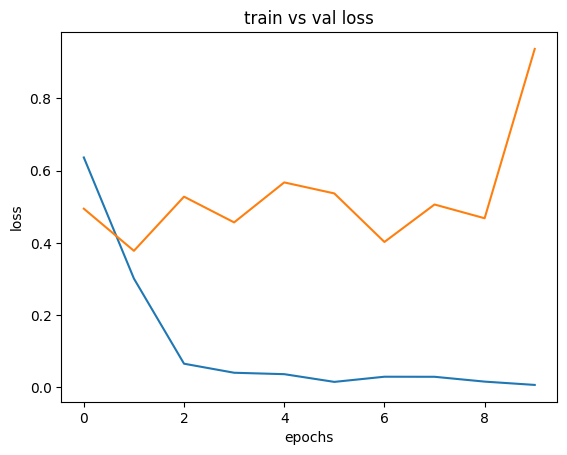

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train vs val loss')
plt.show()

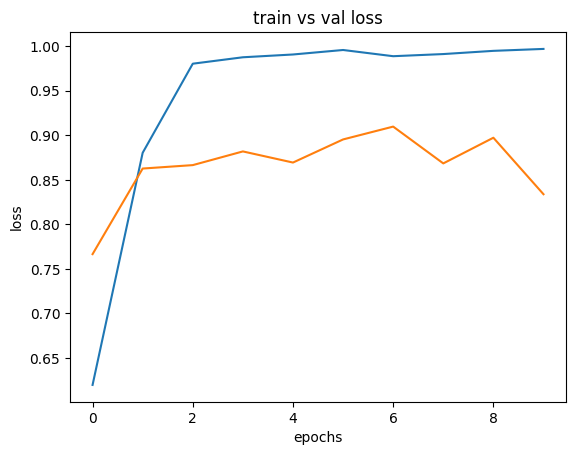

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train vs val loss')
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix
y_proba=model.predict(test_dataset.batch(16))
y_pred=np.argmax(y_proba.logits,axis=1)
cm=confusion_matrix(y_test,y_pred)

66/66 [==============================] - 4s 67ms/step


## Saving and loading model

In [37]:
model.save_pretrained("sarcasm_detection")

In [38]:
my_model=TFDistilBertForSequenceClassification.from_pretrained('sarcasm_detection')

Some layers from the model checkpoint at sarcasm_detection were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at sarcasm_detection and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Making predictions

In [47]:
def prediction(text):
  text=preprocess_text(text)
  inputs=tokenizer(text,padding=True,truncation=True,max_length= max_len,return_tensors='tf')
  logits=my_model(inputs).logits

  probabilities=tf.nn.softmax(logits,axis=1).numpy()
  predicted_label=np.argmax(probabilities,axis=1)

  if predicted_label==1:
    print("Sarcastic")
  else:
    print("not sarcastic")
